In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pybrain.structure import FeedForwardNetwork
from pybrain.structure import LinearLayer, SigmoidLayer, TanhLayer, ReluLayer
from pybrain.structure import FullConnection
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.datasets import SupervisedDataSet
%matplotlib inline

In [2]:
# Lets first consider the dynamics of the system, lets make this final it looks okay.
# let the price be anything between 0 and 100
def getImpactPrice(price, amount):
    if amount < 50:
        return max(price*(1-0.0000008*amount*np.sqrt(amount)), 0)
    else:
        return max(price*(1-0.00000012*amount*amount), 0)
        #p = max(price*(1-0.08*amount*amount*amount), 0)

In [3]:
# to add the random component in the price
def addRandom(price):
    p = min(100, max(0, price + np.random.normal(0, 0.1)))
    return p

In [51]:
def getRewardState(state, action):
    '''it takes current state and action, returns next state and reward generated in this state'''
    newState = [0 for s in state]
    price = getImpactPrice(state[0], action)
    reward = price*action
    newState[0] = addRandom(price)
    newState[1] = max(state[1] - action, 0)
    newState[2] = state[2] + 1
    
    return (reward, newState)

In [52]:
# function to get the terminal reward
def getTerminalReward(state):
    ''' This function will return terminal reward based on terminal state provide'''
    price = getImpactPrice(state[0], state[1])
    reward = price*state[1]
    return reward

In [53]:
T = 20
# as general rule of thumb is to put lambda value as 0.9 in TD(lambda) algo, I would put the same here
lambbda = 0.95
# implenting actor critic method, lets see if it converges or not
# we will consider neural network as function approximater and ploicy approximater as well 
# input for the neural network will be the state : [price, stock, time]
# our neural network architecture will be as follows
# input layer will be 3 nodes based on state
# output layer will be 2 nodes, one for value and one for policy
# right now we will consider 1 hidden layer with 10 nodes, network will be [3,10,2]

In [54]:
valNet = FeedForwardNetwork()
inLayer1 = LinearLayer(3)
hiddenLayer1 = TanhLayer(10)
outputLayer1 = ReluLayer(1)
valNet.addInputModule(inLayer1)
valNet.addModule(hiddenLayer1)
valNet.addOutputModule(outputLayer1)

in_to_hidden1 = FullConnection(inLayer1, hiddenLayer1)
hidden_to_out1 = FullConnection(hiddenLayer1, outputLayer1)

valNet.addConnection(in_to_hidden1)
valNet.addConnection(hidden_to_out1)

valNet.sortModules()

In [55]:
policyNet = FeedForwardNetwork()
inLayer2 = LinearLayer(3)
hiddenLayer2 = TanhLayer(10)
outputLayer2 = ReluLayer(1)

policyNet.addInputModule(inLayer2)
policyNet.addModule(hiddenLayer2)
policyNet.addOutputModule(outputLayer2)

in_to_hidden2 = FullConnection(inLayer2, hiddenLayer2)
hidden_to_out2 = FullConnection(hiddenLayer2, outputLayer2)

policyNet.addConnection(in_to_hidden2)
policyNet.addConnection(hidden_to_out2)

policyNet.sortModules()

In [56]:
dsVal = SupervisedDataSet(3,1)
dsPolicy = SupervisedDataSet(3,1)
trainerVal = BackpropTrainer(valNet, dsVal)
trainerPolicy = BackpropTrainer(policyNet, dsPolicy)

In [57]:
# as we can see this works for function approximation very well
# we can use it for our purpose

# now lets implement the actor critic method here and see if it works or not
# let us take number of iterations as 10000 initially and then we will see later if it works
N = 1000
error = [0 for i in range(N)]

while N > 0:
    # generate the initial state and start state = [price, stocks, 1]
    state = [np.random.random()*100, 1000.0, 1]
    z = 1.0
    t = 0
    dsVal.clear()
    dsPolicy.clear()
    while t < (T-1) and state[1] > 0:
        action = min(max(policyNet.activate(state) + np.random.normal(0, 5), 0), state[1])
        value = valNet.activate(state)
        (reward, newState) = getRewardState(state, action)
        #z = 1
        # based on above get the delta error value as below
        if t == T-2:
            delta = reward + getTerminalReward(newState) - value
            z = 1.0
        else:
            delta = reward + valNet.activate(newState) - value
        #now we do make neural network run based on the error, delta value above
        delta_z = delta*z
        z = z*lambbda
        dsVal.clear()
        dsPolicy.clear()
        dsVal.addSample(state, value-delta_z)
        dsPolicy.addSample(state, max(action - delta, state[1]))
        #print(z)
        #error[N-1] = trainer.train()
        trainerPolicy.train()
        trainerVal.train()
        t = t + 1
    if N % 100 == 0:
        print(N)
    #print(N)
    N = N -1
#print(theta)
#print(nu)
print('learning completed')

1000
900
800
700
600
500
400
300
200
100
learning completed


In [58]:
def actionValue():
    u = [0 for i in range(20)]
    val = [0 for i in range(20)]
    prices = [0 for i in range(20)]
    T = 20
    #for i in range(1000):
    value = 0.0
    state = [np.random.random()*100, 1000, 0]
    print(state[0])
    t = 0
    while t < T and state[1] > 0:
        if t == T-1:
            #u_t = s_t[1]
            val[t] = getTerminalReward(state)
            u[t] = state[1]
        else:
            u[t] = policyNet.activate(state)
            (reward, s) = getRewardState(state, u[t])
            val[t] = valNet.activate(state)
            print(action, val[t], state)
        prices[t] = state[0]
        state = s
        t = t + 1
    return (val, u, prices)

70.43925841407788
[ 996.11391788] [-0.] [70.43925841407788, 1000, 0]
[ 996.11391788] [-0.] [array([ 61.97849282]), array([  6.82121026e-13]), 1]


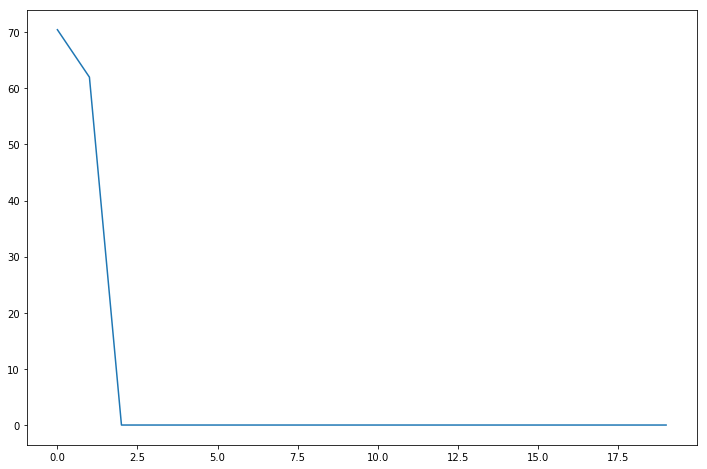

In [59]:
(val, u, price) = actionValue()
plt.figure(figsize=(12,8))
plt.plot(price)

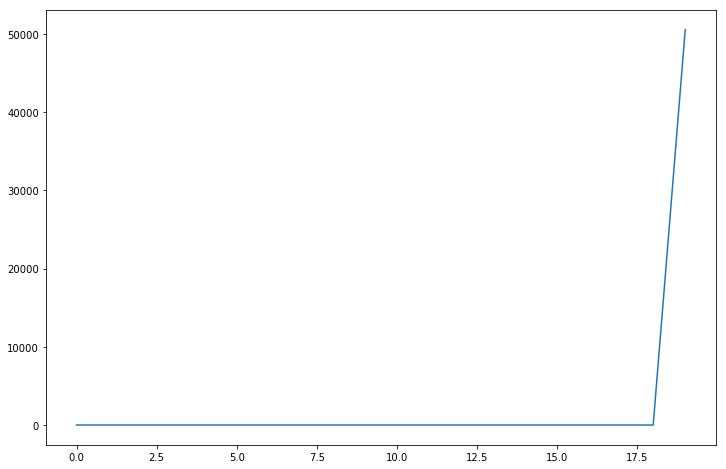

In [46]:
plt.figure(figsize=(12,8))
plt.plot(val)

In [48]:
valNet.activate([23, 1000, 0])

array([-0.])

In [50]:
policyNet.activate([23, 1000, 0])

array([-0.])